# Hand Drawn Captcha Models for Web App

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='../images/model_plot.png', show_shapes=True, show_layer_names=True)

from PIL import Image
import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

In [4]:
from emnist import list_datasets
from emnist import extract_training_samples, extract_test_samples

In [5]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

## Load Data

In [6]:
len(os.listdir('../data/drawn/'))

1013366

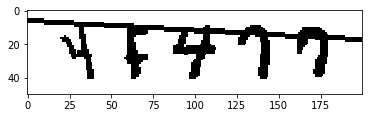

In [7]:
img=cv2.imread('../data/drawn/4f477.png',cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap=plt.cm.binary)

In [8]:
nums = '0123456789'
chars = '0123456789' + string.ascii_lowercase
num_chars = len(chars)

def data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)
            
def mix_img(img, fill_val = 0):
    # random rotate value
    ang_list = [-5,-4,-3,-2,-1,0,0,0,0,0,1,2,3,4,5]
    ang = random.choice(ang_list)
    # rotate image
    im = Image.fromarray(img)
    img = np.asarray(im.rotate(ang))
    
    return img

def load_drawn_data(from_src=False):
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    leng = 750000#len(os.listdir(path))
        
    X = np.zeros((leng, 50, 200, 1)) 
    y = np.zeros((5, leng, num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        
        if i == leng:
            break
            
        img_path = path + name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, np.array(labels)

def load_less_numbers(from_src=False):
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    leng = len(os.listdir(path))
        
    X = []
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        if i == leng:
            break
            
        label = name[:-4]
        ce=0
        for i in list(label):
            if i in nums:
                ce += 1
        if ce > 3:
            continue
            
        img_path = path + name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        X.append(img)
        labels.append(label)
        
    y = np.zeros((5, len(labels), num_chars)) 

    for i, name in enumerate(labels):
    # Define labels using OneHotEncoding
        target = np.zeros((5, num_chars))
        for j, l in enumerate(name):
            ind = chars.find(l)
            target[j, ind] = 1

        y[:, i] = target

    return np.array(X), y, np.array(labels)

In [9]:
data_check(from_src=True)

In [10]:
nX, ny, nlabels = load_drawn_data(from_src=True)

In [11]:
nX.shape, ny.shape, nlabels.shape

((750000, 50, 200, 1), (5, 750000, 36), (750000,))

In [11]:
lX, ly, llabels = load_less_numbers(from_src=True)

In [13]:
X, y, labels = lX[:350000], ly[:,:350000,:], llabels[:350000]

## Build Model

### 4 CNN Layers

In [20]:
# Model Outline
input_shape = (50, 200, 1)
i = [32,64,32,16,7]

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(i[0], (i[4], i[4]), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(i[1], (i[4], i[4]), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(i[2], (i[4], i[4]), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   

cn4 = Conv2D(i[3], (i[4], i[4]), padding='same', activation='relu')(mp3)
bn = BatchNormalization()(cn4)
mp4 = MaxPooling2D(padding='same')(bn) 

# Flatten and Dense layers
flat = Flatten()(mp4)
output = []
for _ in range(5):
    dens1 = Dense(128, activation='relu')(flat)
    drop = Dropout(0.5)(dens1)
    result = Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [21]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [22]:
model.summary();

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 50, 200, 32)  1600        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 25, 100, 32)  0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 25, 100, 64)  100416      max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [23]:
history = model.fit(nX, [ny[0], ny[1], ny[2], ny[3], ny[4]],
                 batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Train on 600000 samples, validate on 150000 samples
Epoch 1/10
600000/600000 - 496s - loss: 2.9324 - dense_21_loss: 0.5737 - dense_23_loss: 0.5977 - dense_25_loss: 0.5950 - dense_27_loss: 0.5970 - dense_29_loss: 0.5688 - dense_21_accuracy: 0.8274 - dense_23_accuracy: 0.8206 - dense_25_accuracy: 0.8217 - dense_27_accuracy: 0.8210 - dense_29_accuracy: 0.8285 - val_loss: 1.1986 - val_dense_21_loss: 0.2363 - val_dense_23_loss: 0.2426 - val_dense_25_loss: 0.2426 - val_dense_27_loss: 0.2411 - val_dense_29_loss: 0.2360 - val_dense_21_accuracy: 0.9170 - val_dense_23_accuracy: 0.9149 - val_dense_25_accuracy: 0.9164 - val_dense_27_accuracy: 0.9163 - val_dense_29_accuracy: 0.9166
Epoch 2/10
600000/600000 - 482s - loss: 1.3049 - dense_21_loss: 0.2565 - dense_23_loss: 0.2640 - dense_25_loss: 0.2661 - dense_27_loss: 0.2632 - dense_29_loss: 0.2550 - dense_21_accuracy: 0.9140 - dense_23_accuracy: 0.9120 - dense_25_accuracy: 0.9120 - dense_27_accuracy: 0.9128 - dense_29_accuracy: 0.9148 - val_loss: 1.1

In [24]:
acc, loss = [], []
for i, l in enumerate(history.history.values()):
    if i >= 17:
        acc.append(l)
    elif i >= 12:
        loss.append(l)
        #print(i)

In [30]:
[max(i).round(3) for i in acc]

[0.935, 0.934, 0.933, 0.934, 0.935]

''

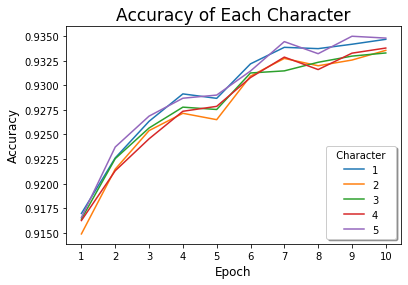

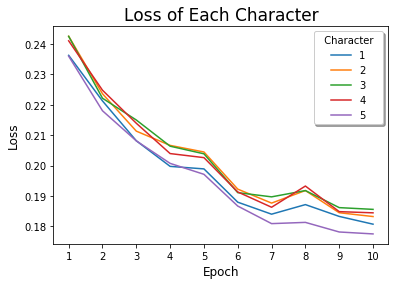

In [27]:
# Get number of epochs
epochs = range(len(acc[0]))

# Plot validation accuracy per epoch
for i in acc:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='lower right', title='  Character  ', shadow=True)
plt.title('Accuracy of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Accuracy', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

plt.savefig('../images/drawn_cap_acch.png')
plt.figure()

# Plot training and validation loss per epoch
for i in loss:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='upper right', title='  Character  ', shadow=True)
plt.title('Loss of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Loss', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_lossf.png')
;

In [28]:
#model.save('../models/4cnn_draw_model.h5')

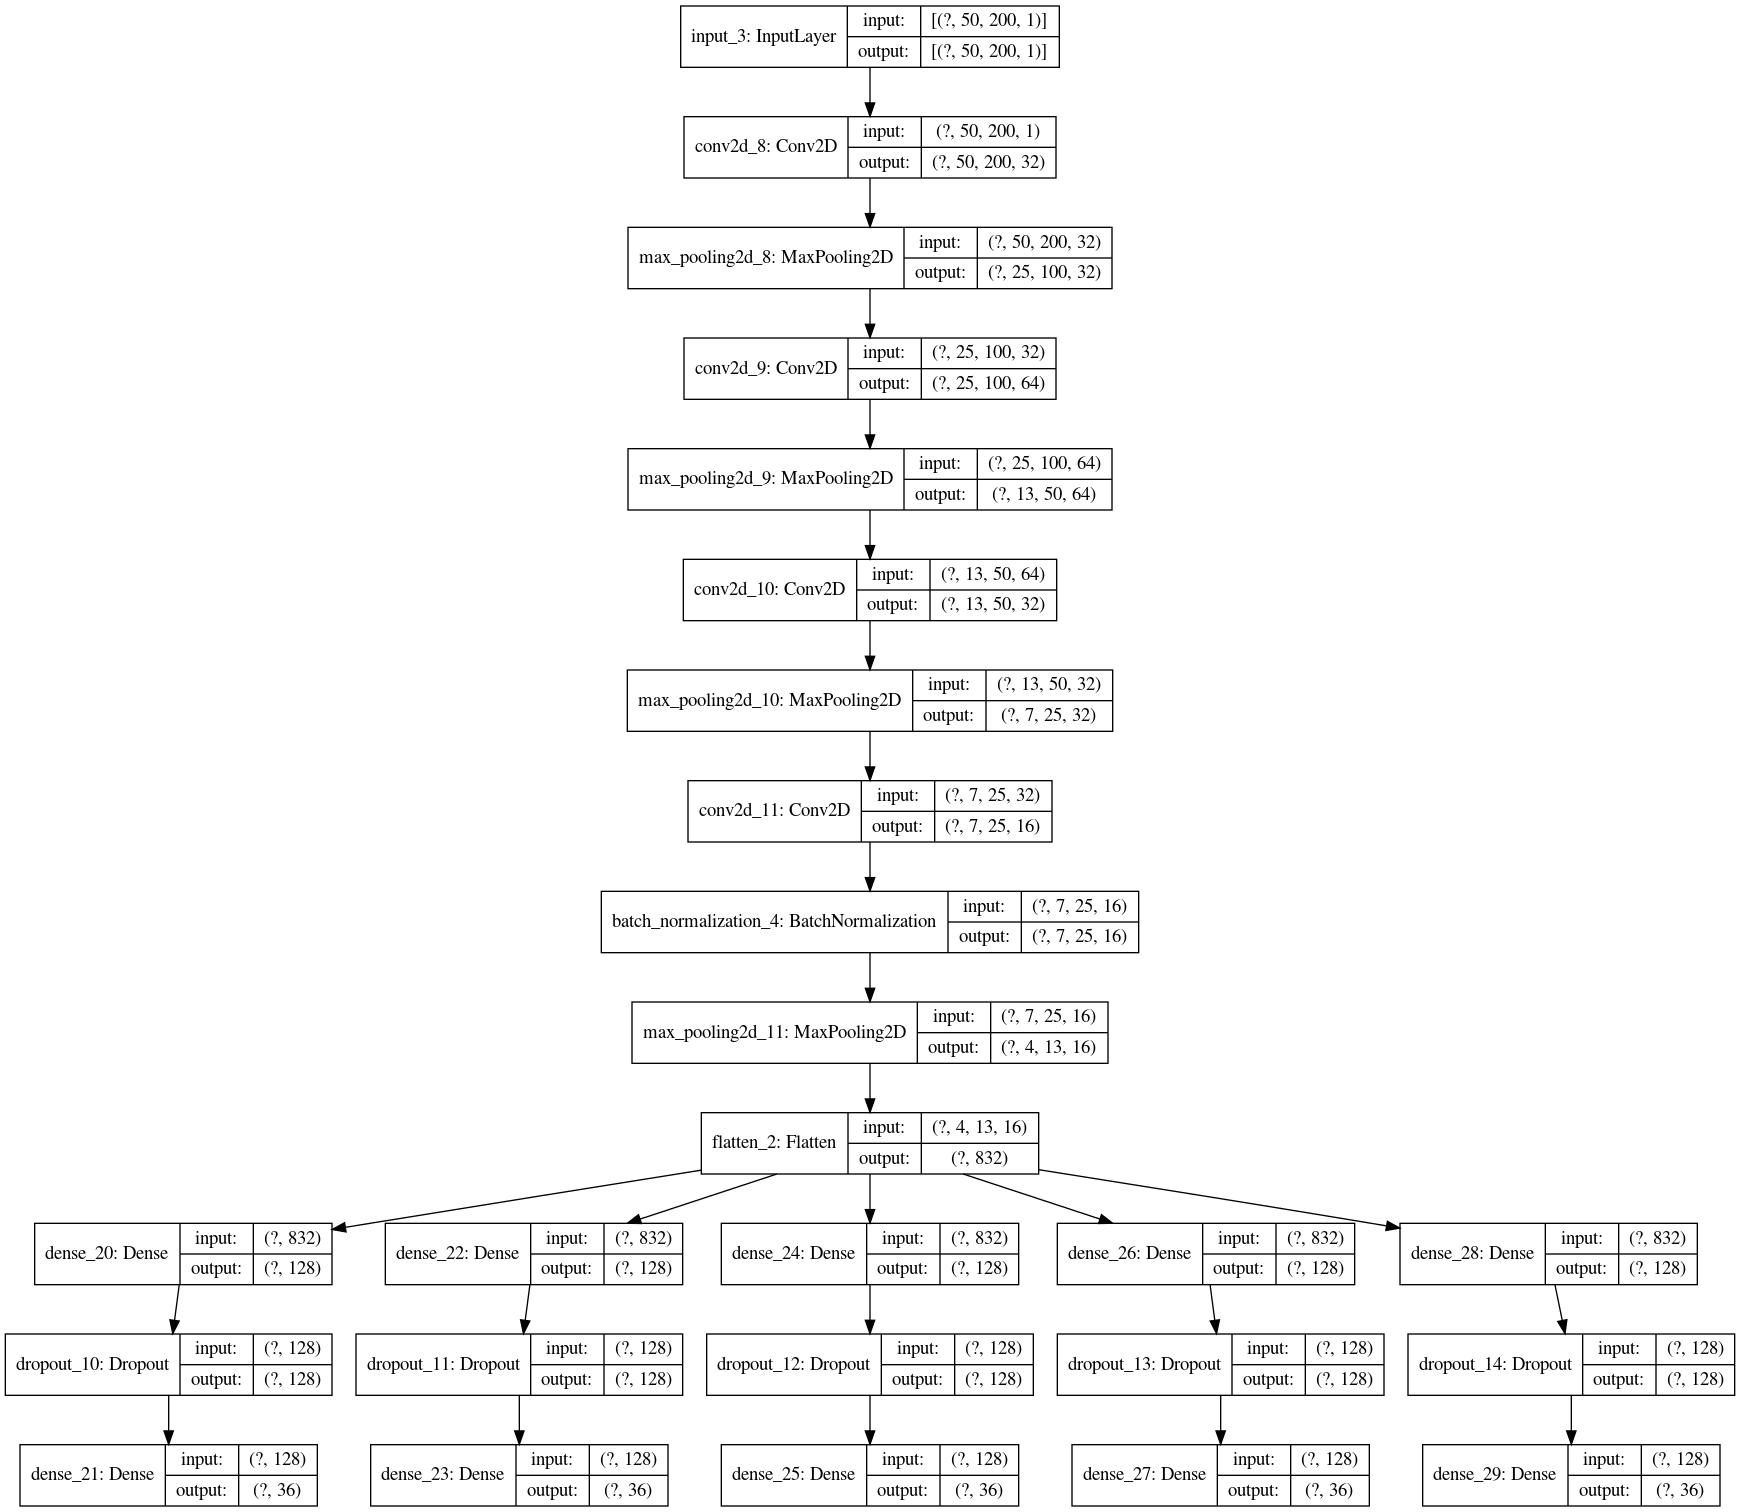

In [29]:
plot_model(model, to_file='../images/model_plot.png', show_shapes=True, show_layer_names=True)

### 5 CNN Layers

In [12]:
# Model Outline
input_shape = (50, 200, 1)
i = [32,64,32,32,7,16]

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(i[0], (i[4], i[4]), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(i[1], (i[4], i[4]), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(i[2], (i[4], i[4]), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   

cn4 = Conv2D(i[3], (i[4], i[4]), padding='same', activation='relu')(mp3)
bn = BatchNormalization()(cn4)
mp4 = MaxPooling2D(padding='same')(bn) 

cn5 = Conv2D(i[5], (i[4], i[4]), padding='same', activation='relu')(mp4)
mp5 = MaxPooling2D(padding='same')(cn5)

# Flatten and Dense layers
flat = Flatten()(mp5)
output = []
for _ in range(5):
    dens1 = Dense(128, activation='relu')(flat)
    drop = Dropout(0.5)(dens1)
    result = Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [13]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [14]:
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 32)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 64)  100416      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
history = model.fit(nX, [ny[0], ny[1], ny[2], ny[3], ny[4]],
                 batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Train on 600000 samples, validate on 150000 samples
Epoch 1/10
600000/600000 - 510s - loss: 3.5574 - dense_1_loss: 0.6886 - dense_3_loss: 0.7310 - dense_5_loss: 0.7421 - dense_7_loss: 0.7120 - dense_9_loss: 0.6835 - dense_1_accuracy: 0.7941 - dense_3_accuracy: 0.7821 - dense_5_accuracy: 0.7793 - dense_7_accuracy: 0.7879 - dense_9_accuracy: 0.7953 - val_loss: 1.3584 - val_dense_1_loss: 0.2635 - val_dense_3_loss: 0.2793 - val_dense_5_loss: 0.2742 - val_dense_7_loss: 0.2751 - val_dense_9_loss: 0.2664 - val_dense_1_accuracy: 0.9121 - val_dense_3_accuracy: 0.9069 - val_dense_5_accuracy: 0.9096 - val_dense_7_accuracy: 0.9095 - val_dense_9_accuracy: 0.9113
Epoch 2/10
600000/600000 - 496s - loss: 1.4989 - dense_1_loss: 0.2908 - dense_3_loss: 0.3065 - dense_5_loss: 0.3133 - dense_7_loss: 0.3002 - dense_9_loss: 0.2880 - dense_1_accuracy: 0.9069 - dense_3_accuracy: 0.9033 - dense_5_accuracy: 0.9017 - dense_7_accuracy: 0.9050 - dense_9_accuracy: 0.9075 - val_loss: 1.1906 - val_dense_1_loss: 0.2341

In [16]:
acc, loss = [], []
for i, l in enumerate(history.history.values()):
    if i >= 17:
        acc.append(l)
    elif i >= 12:
        loss.append(l)
        #print(i)

In [17]:
[max(i).round(2) for i in acc]

[0.93, 0.93, 0.93, 0.93, 0.93]

''

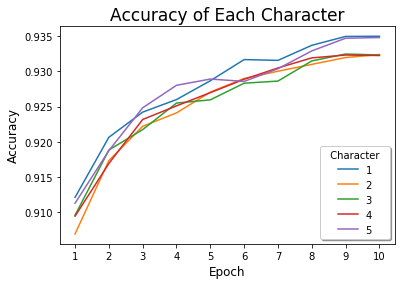

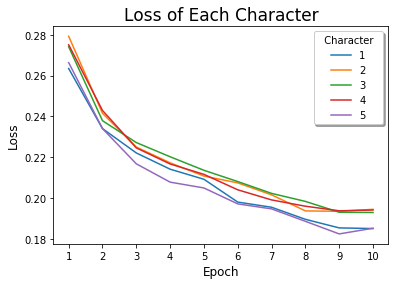

In [18]:
# Get number of epochs
epochs = range(len(acc[0]))

# Plot validation accuracy per epoch
for i in acc:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='lower right', title='  Character  ', shadow=True)
plt.title('Accuracy of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Accuracy', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_acc_.png')
plt.figure()

# Plot training and validation loss per epoch
for i in loss:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='upper right', title='  Character  ', shadow=True)
plt.title('Loss of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Loss', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_loss_.png')
;

In [19]:
def predict_one(img, true):
    # Find prediction for each character output
    onehotpred = np.array(model.predict(img.reshape(1,50,200,1))).reshape(5,36)    
    pred = ''
    
    # Concatenate each character prediction
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

In [20]:
img=cv2.imread('../data/drawn/34f3e.png',cv2.IMREAD_UNCHANGED)
img = img / 255.0
img = img.reshape(50, 200, 1)
predict_one(img, '34f3e')

('34f3e', '34f3e')

In [21]:
#model.save('../models/5cnn_draw_model.h5')

### Model with Less Numbers Data

In [14]:
# Model Outline
input_shape = (50, 200, 1)
i = [32,64,32,16,7]

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(i[0], (i[4], i[4]), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(i[1], (i[4], i[4]), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(i[2], (i[4], i[4]), padding='same', activation='relu')(mp2)
bn1 = BatchNormalization()(cn3)
mp3 = MaxPooling2D(padding='same')(bn1)   

cn4 = Conv2D(i[3], (i[4], i[4]), padding='same', activation='relu')(mp3)
bn2 = BatchNormalization()(cn4)
mp4 = MaxPooling2D(padding='same')(bn2) 

# Flatten and Dense layers
flat = Flatten()(mp4)
output = []
for _ in range(5):
    dens1 = Dense(64, activation='relu')(flat)
    drop = Dropout(0.5)(dens1)
    result = Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [15]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [16]:
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 32)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 64)  100416      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [17]:
history = model.fit(X, [y[0], y[1], y[2], y[3], y[4]],
                 batch_size=256, epochs=15, verbose=2, validation_split=0.2)

Train on 280000 samples, validate on 70000 samples
Epoch 1/15
280000/280000 - 238s - loss: 6.1425 - dense_1_loss: 1.2059 - dense_3_loss: 1.2410 - dense_5_loss: 1.2600 - dense_7_loss: 1.2634 - dense_9_loss: 1.1714 - dense_1_accuracy: 0.6405 - dense_3_accuracy: 0.6340 - dense_5_accuracy: 0.6216 - dense_7_accuracy: 0.6258 - dense_9_accuracy: 0.6505 - val_loss: 1.7009 - val_dense_1_loss: 0.3282 - val_dense_3_loss: 0.3440 - val_dense_5_loss: 0.3539 - val_dense_7_loss: 0.3430 - val_dense_9_loss: 0.3317 - val_dense_1_accuracy: 0.8846 - val_dense_3_accuracy: 0.8831 - val_dense_5_accuracy: 0.8817 - val_dense_7_accuracy: 0.8808 - val_dense_9_accuracy: 0.8863
Epoch 2/15
280000/280000 - 227s - loss: 2.1047 - dense_1_loss: 0.4085 - dense_3_loss: 0.4239 - dense_5_loss: 0.4417 - dense_7_loss: 0.4270 - dense_9_loss: 0.4036 - dense_1_accuracy: 0.8646 - dense_3_accuracy: 0.8609 - dense_5_accuracy: 0.8536 - dense_7_accuracy: 0.8588 - dense_9_accuracy: 0.8669 - val_loss: 1.5002 - val_dense_1_loss: 0.2924 

Epoch 15/15
280000/280000 - 226s - loss: 1.0149 - dense_1_loss: 0.2014 - dense_3_loss: 0.2065 - dense_5_loss: 0.2056 - dense_7_loss: 0.2020 - dense_9_loss: 0.1993 - dense_1_accuracy: 0.9263 - dense_3_accuracy: 0.9247 - dense_5_accuracy: 0.9259 - dense_7_accuracy: 0.9268 - dense_9_accuracy: 0.9274 - val_loss: 1.1360 - val_dense_1_loss: 0.2218 - val_dense_3_loss: 0.2303 - val_dense_5_loss: 0.2356 - val_dense_7_loss: 0.2286 - val_dense_9_loss: 0.2193 - val_dense_1_accuracy: 0.9237 - val_dense_3_accuracy: 0.9236 - val_dense_5_accuracy: 0.9216 - val_dense_7_accuracy: 0.9240 - val_dense_9_accuracy: 0.9242


In [18]:
acc, loss = [], []
for i, l in enumerate(history.history.values()):
    if i >= 17:
        acc.append(l)
    elif i >= 12:
        loss.append(l)
        #print(i)

In [19]:
[max(i).round(2) for i in acc]

[0.92, 0.92, 0.92, 0.92, 0.93]

''

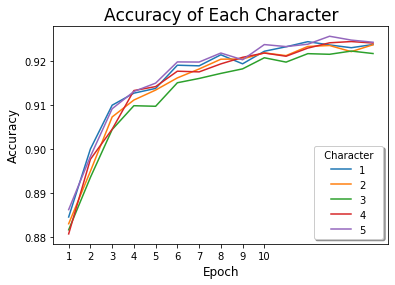

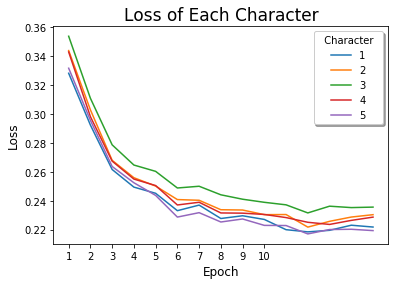

In [47]:
# Get number of epochs
epochs = range(len(acc[0]))

# Plot validation accuracy per epoch
for i in acc:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='lower right', title='  Character  ', shadow=True)
plt.title('Accuracy of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Accuracy', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_accf.png')
plt.figure()

# Plot training and validation loss per epoch
for i in loss:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='upper right', title='  Character  ', shadow=True)
plt.title('Loss of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Loss', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_lossf.png')
;

In [22]:
#model.save('../models/fin_draw_model.h5')

In [26]:
lst_of_chars = []
for s in labels:
    lst_of_chars += [char for char in s]
len(lst_of_chars)/len(labels), len(lst_of_chars)

(5.0, 1750000)

In [48]:
pd.Series(lst_of_chars).value_counts()

e    122278
1     97113
t     93435
7     91342
3     89774
0     88659
6     87822
2     87728
9     87177
8     86865
4     85715
5     80762
l     79141
r     73511
n     60449
d     53841
a     53386
h     47067
b     27921
g     20276
q     16904
v     15830
u     15667
x     15665
c     15576
o     15561
i     15147
z     15065
m     14927
w     14898
s     14799
k     14245
f     14221
p     13488
y     13171
j     10574
dtype: int64